<img src='https://hospitalityinsights.ehl.edu/hubfs/AdobeStock_308332890.jpeg' align='left' width='75%'/>

**Authors:** Nate Currit <br>
**Copyright:** 2022 Nate Currit <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Geographic Object-Based Image Analysis (GEOBIA)</h3></div>

# INTRODUCTION

### Learning outcomes

At the end of this notebook you will know;
* The steps of GEOBIA image classification
* How to perform GEOBIA using open source tools


### Outline

Here you could describe your notebook, and perhaps include <a href="https://notebook.wekeo.eu/" target="_blank">links</a> to any relevant external content. 

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Background](#background)
 2. [Segmentation](#segmentation)
 3. [Attribution](#attribution)
 4. [Classification](#classification)
 5. [Challenge](#challenge)


<hr>

<div class="alert alert-info" role="alert">

## <a id='background'></a>1. Background
[Back to top](#TOC_TOP)

</div>

## Pixel-based vs Object-based classifications
Two broad types of image classification exist: pixel-based and object-based. In **pixel-based** classifications, individual pixels are classified indepently of neighboring pixels. 

**Object-based** classifications recognize spatial relationships between neighboring pixels.

## High resolution vs Low resolution imagery
Orbital and sub-orbital imagery has 4 unique kinds of resolution: spatial, spectral, radiometric and temporal. This section focuses on spatial resolution in the context of GEOBIA. 

A few new terms have been proposed and used: H' high resolution imagery and L' low resolution imagery. Here, high and low spatial resolution are defined by their relation to geographic objects of interest on the ground. H' resolution imagery has pixels that are smaller than objects of interest. That is, there are more than 1 H' pixels per object of interest. L' resolution imagery has 1 or fewer pixels per object of interest

In [43]:
# Runs functions found in an accompanying notebook 
%run ./functions.ipynb

# This is to hide warnings and keep the notebook uncluttered 
# (it isn't a good idea to do this in production)
# import warnings
# warnings.filterwarnings('ignore')

## Data for this tutorial
#### Data used (example - you can change this to suit your data sets)

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level-1B | EO:EUM:DAT:0411 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_1_RBT___NTC?query=SLSTR&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SL_1_RBT___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_1_RBT___&initial=1" target="_blank">link</a> |### Data used (example - you can change this to suit your data sets)

In [2]:
# Open image for visualization and analysis as a datasetreader object
src = rasterio.open("data/concise.tif")
# Read the raw data as a numpy array
image = src.read()

#### First, let's learn a little bit about this image, like how many bands it has, the data types of the bands, its shape, and its minimum and maximum values.

In [3]:
print(f"Number of bands: {src.count}")
print(f"Number of rows/columns: {src.height} / {src.width}")
print(f"Pixel data types per band: {src.dtypes}")
print(f"Band 1 (blue) min/max: {image[0].min()} / {image[0].max()}")
print(f"Band 2 (green) min/max: {image[1].min()} / {image[1].max()}")
print(f"Band 3 (red) min/max: {image[2].min()} / {image[2].max()}")
print(f"Band 4 (nir) min/max: {image[3].min()} / {image[3].max()}")

Number of bands: 4
Number of rows/columns: 445 / 554
Pixel data types per band: ('uint16', 'uint16', 'uint16', 'uint16')
Band 1 (blue) min/max: 1133 / 4676
Band 2 (green) min/max: 1209 / 5280
Band 3 (red) min/max: 1088 / 5296
Band 4 (nir) min/max: 1095 / 7036


#### The values above are scaled values. Dividing them by 100 produces values representative of the percent reflectance.

In [4]:
print(f"Band 1 (blue) min/max: {image[0].min()/100}% / {image[0].max()/100}%")
print(f"Band 2 (green) min/max: {image[1].min()/100}% / {image[1].max()/100}%")
print(f"Band 3 (red) min/max: {image[2].min()/100}% / {image[2].max()/100}%")
print(f"Band 4 (nir) min/max: {image[3].min()/100}% / {image[3].max()/100}%")

Band 1 (blue) min/max: 11.33% / 46.76%
Band 2 (green) min/max: 12.09% / 52.8%
Band 3 (red) min/max: 10.88% / 52.96%
Band 4 (nir) min/max: 10.95% / 70.36%


#### For a few reasons, but especially for visualization, it is best to have pixel values as ratios scaled from 0 to 1, so we divide by 10,000.

In [5]:
image = image / 10000

In [6]:
print(f"Band 1 (blue) min/max: {image[0].min()} / {image[0].max()}")
print(f"Band 2 (green) min/max: {image[1].min()} / {image[1].max()}")
print(f"Band 3 (red) min/max: {image[2].min()} / {image[2].max()}")
print(f"Band 4 (nir) min/max: {image[3].min()} / {image[3].max()}")

Band 1 (blue) min/max: 0.1133 / 0.4676
Band 2 (green) min/max: 0.1209 / 0.528
Band 3 (red) min/max: 0.1088 / 0.5296
Band 4 (nir) min/max: 0.1095 / 0.7036


#### Now, let's view and interpret the image!

This is an image of a western shore of Lake Neuchatel in Switzerland. The community to the south is Concise and the community to the north is Vaumarcus. The image is a true-color composite that has been linearly stretched for better visualization. The dark green patches that run through the middle of the image are forest. Agricultural fields at various stages of growth are found in unforested, non-urban areas. Some variations in color are seen in the lake, depending on depth and sediment load.

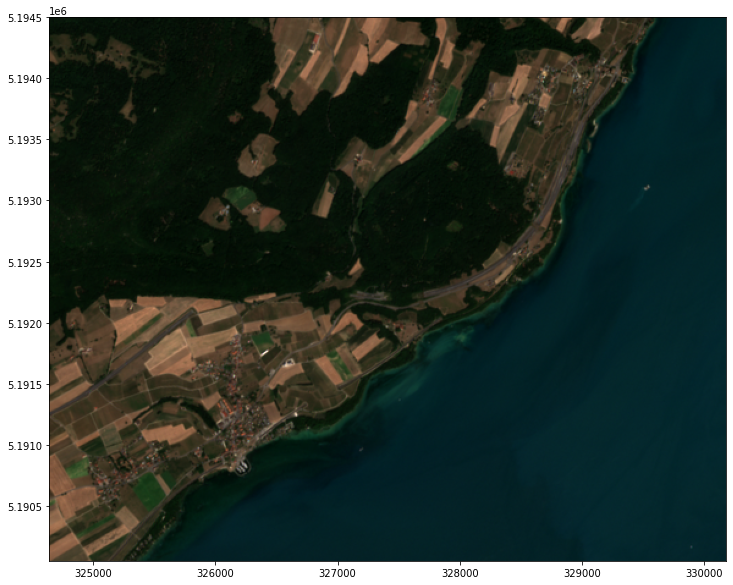

In [7]:
# The following 2 lines "stretch" pixels between the middle 95% of pixel values
p25, p975 = np.percentile(image, (2.5, 97.5))
rgb = exposure.rescale_intensity(image, in_range=(p25, p975))

fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)

#### Interpreting the histogram

The red, green, and blue histograms correspond to the red, green and blue bands of the image scene. The solid black line in the near-infrared histogram. Each band has a peaked mode in the histogram to the left of the figure, representing low reflectance pixels corresponding to the lake. The higher reflectance pixels to the right of the histogram are more dispered (more or less depending on the band) and correspond to the different land cover types. The near-infrared band has the greatest land-cover dispersion of pixel values. 

Text(0.5, 1.0, 'Pixel distributions per color band')

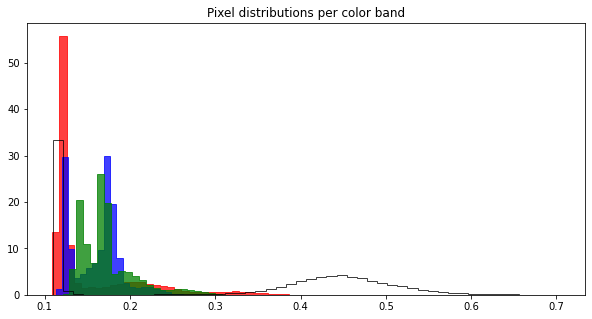

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(image[2].flatten(), 50, density=True, histtype='stepfilled', facecolor='r', ec='r', alpha=0.75)
ax.hist(image[0].flatten(), 50, density=True, histtype='stepfilled', facecolor='b', ec='b', alpha=0.75)
ax.hist(image[1].flatten(), 50, density=True, histtype='stepfilled', facecolor='g', ec='g', alpha=0.75)
ax.hist(image[3].flatten(), 50, density=True, histtype='step', ec='k', alpha=0.75)
ax.set_title("Pixel distributions per color band")

<div class="alert alert-info" role="alert">

## <a id='segmentation'></a>2. Segmentation
[Back to top](#TOC_TOP)

</div>

Segmentation is what primarily distinguishes GEOBIA from pixel-based classification methods. It is the most critical part of the GEOBIA process.

Before running the segmentation code below, we load a few utilities.

#### Select algorithm and set parameters

There are many segementation algorithms that can be selected using the scikit-image package, including the Simple Linear Iterative Clustering (SLIC), Felzenszwalb and Quickshift algorithms. It the tutorial materials below you will use the Quickshift algorithm. In the challenge section at the of the tutorial you will try the other algorithms.

Each algorithm has unique parameters that you can alter. Indeed, your task is to select parameters that partition your image into meaningful segments that you can later classify. Determining optimum parameters is usually done by trial and error and varies from image to image depending on location, illumination, image contrast, etc.

In [9]:
slic_params = {
    'n_segments': 2500,             # default = 100
    'compactness': 3.5,             # default = 10.0
    'max_num_iter': 20,             # default = 10
    'sigma': 0,                     # default = 0
    'convert2lab': True,            # default = None, but True is highly recommended for RGB images
    'enforce_connectivity': True,   # default = True
    'min_size_factor': 0.5,         # default = 0.5
    'max_size_factor': 3,           # default = 3
    'slic_zero': False,             # default = False (if True, runs zero parameter version of SLIC)
    'channel_axis': 2               # for our RGB image this should always be 2
}

felz_params = {
    'scale': 2.7,      # default = 1
    'sigma': 0.4,      # default = 0.8
    'min_size': 22,    # default = 20
    'channel_axis': 2  # for our RGB image this should always be 2
}

quickshift_params = {
    'ratio': 0.5,           # default = 1
    'kernel_size': 2,       # default = 5
    'max_dist': 5,          # default = 10
    'sigma': 0.2,           # default = 0
    'convert2lab': True,    # default = True
    'channel_axis': 2       # for our RGB image this should always be 2
}

#### Segment image

In [10]:
print(f"Starting segmentation.", end="...")

# SLIC
# rout = segmentation(model=slic, params=slic_params, image=image[:3])
# Felzenszwalb
# rout = segmentation(model=felzenszwalb, params=felz_params, image=image[:3], sieve_size=30)
# Quickshift
rout = segmentation(model=quickshift, params=quickshift_params, image=image[:3])

print(f"done.")

Starting segmentation....done.


#### Vectorize raster segments

In [11]:
print(f"Starting vectorization.", end="...")
vout = vectorize(image=rout, transform=src.transform, crs=src.crs.to_epsg())
print(f"done.")

vout.to_file("./segmentation.gpkg", layer="noAttributes", driver="GPKG")

Starting vectorization....done.


#### Visualize segmentation

Now we can visualize the segments overlaid on the image. Over the land you are able to see many segments that correspond to field or forest boundaries. Over the lake, you see many segments that are square (or nearly so) because the Quickshift algorithm 'grows' until a certain limit. If there are no pixel variations that cause the region to 'grow' to a different shape, it will continue growing until it reaches a maximum size, in which case the shape is a square.

<AxesSubplot:>

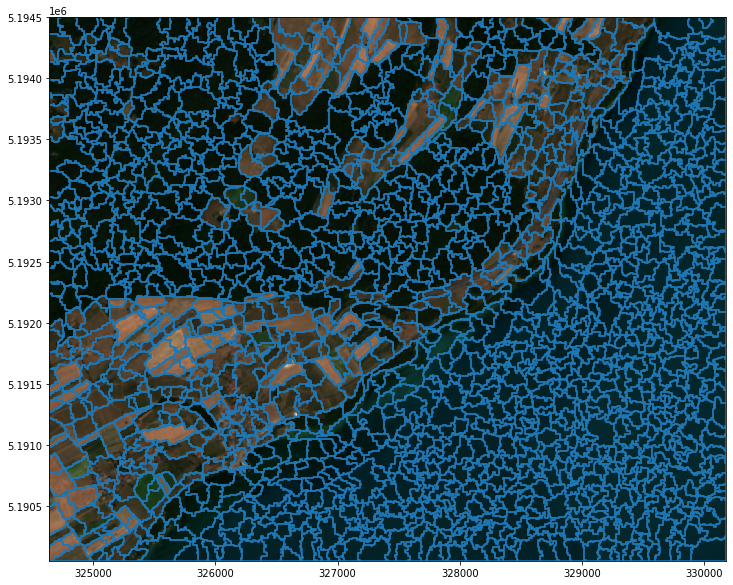

In [12]:
fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
vout.boundary.plot(ax=ax)

<div class="alert alert-info" role="alert">

## <a id='attribution'></a>3. Attribution
[Back to top](#TOC_TOP)

</div>

Segment attributes generally fall into 3 categories, spectral, shape and texture.

#### Spectral
Spectral attributes are zonal statistics of the original spectral image bands based on the segments derived above. For example, the average blue, green, red and near infrared pixels values of each segment are recorded as unique fields in the vector segments file. 

#### Shape
Geographic objects in a region may have unique shapes, depending on the resolution characteristics of the imagery. For example, tree crowns may be round, homes may be square, lakes may be elongated, etc. Depending on the objects visible in the imagery and the shape of the segments derived from the previous steps, an analyst can choose from a variety of shape parameters.

#### Texture
A whole range of texture measures

### Spectral attributes

In [13]:
print(f"Starting add zonal spectral properties.", end="...")
vout = add_zonal_properties(image=image, transform=src.transform, 
                            band_names=['blue', 'green', 'red', 'nir'],
                            gdf=vout)
print(f"done.")

Starting add zonal spectral properties....done.


### Shape attributes

In [14]:
print(f"Starting add shape properties.", end="...")
vout = add_shape_properties(rout, vout, ['area', 'perimeter',
                                        'eccentricity', 
                                        'equivalent_diameter',
                                        'major_axis_length',
                                        'minor_axis_length',
                                        'orientation'])
print(f"done.")

Starting add shape properties....done.


### Texture attributes

In [15]:
print(f"Starting edge detection.", end="...")
edges = sobel_edge_detect(image[3])
print(f"done.")

print(f"Starting add zonal texture properties.", end="...")
vout = add_zonal_properties(image=edges, band_names=['edges'],
                            stats=['mean', 'std'],
                            transform=src.transform, gdf=vout)
print(f"done.")

Starting edge detection....done.
Starting add zonal texture properties....done.


In [16]:
vout.head()

,geometry,blue_mean,green_mean,red_mean,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn
0,"POLYGON ((327480.000 5194500.000, 327480.000 5...",0.127649,0.145959,0.134366,0.563924,4100.0,340.0,0.945644,7.225152,12.741393,4.143561,1.440833,0.034164,0.024765,1
1,"POLYGON ((325060.000 5194500.000, 325060.000 5...",0.126919,0.144490,0.124561,0.503557,7200.0,440.0,0.657429,9.574615,11.696544,8.813541,1.436558,0.046957,0.025664,6
2,"POLYGON ((326310.000 5194500.000, 326310.000 5...",0.141432,0.165116,0.153372,0.481581,11200.0,520.0,0.761851,11.941643,15.305014,9.913859,1.395996,0.045063,0.024198,7
3,"POLYGON ((328330.000 5194500.000, 328330.000 5...",0.156824,0.184952,0.192864,0.427598,11600.0,500.0,0.642805,12.153016,14.218704,10.891953,1.413716,0.024753,0.017278,3
4,"POLYGON ((328630.000 5194500.000, 328630.000 5...",0.174969,0.207304,0.228889,0.420451,10600.0,620.0,0.818265,11.726460,17.666837,10.155622,1.305706,0.023488,0.014566,4


#### Review of attributes

What we see above is the first 5 segments with their final attributes. For each segment there are values representative of the mean blue, green, red and near-infrared pixels within the segment. There are 7 shape parameters for each segment, including area, perimeter, eccentricity, equivalent_diameter, major_axis_length, minor_axis_length, and orientation. The two texture measures are the mean and standard deviation of the pixels from a Sobel edge detection filter. These are the attributes that will be used to classify each segment as described below.

In [21]:
# Open the ground reference training points
ground_data = gpd.read_file("data/training.gpkg", layer='points')
ground_data.head()

,land_cover_desc,land_cover_id,geometry
0,lake-deep,4,MULTIPOINT (328993.501 5190963.713)
1,lake-deep,4,MULTIPOINT (328817.429 5191125.726)
2,lake-deep,4,MULTIPOINT (328833.661 5191186.325)
3,lake-deep,4,MULTIPOINT (328736.573 5190934.442)
4,lake-deep,4,MULTIPOINT (328845.564 5190998.035)


In [29]:
lc_labels = list(ground_data.land_cover_desc.unique())
labels = pd.DataFrame(lc_labels, ground_data.land_cover_id.unique())
labels.columns = ['Land-cover label']
labels

,Land-cover label
4,lake-deep
1,forest
2,grassland-green
3,grassland-light
5,lake-sediment


<AxesSubplot:>

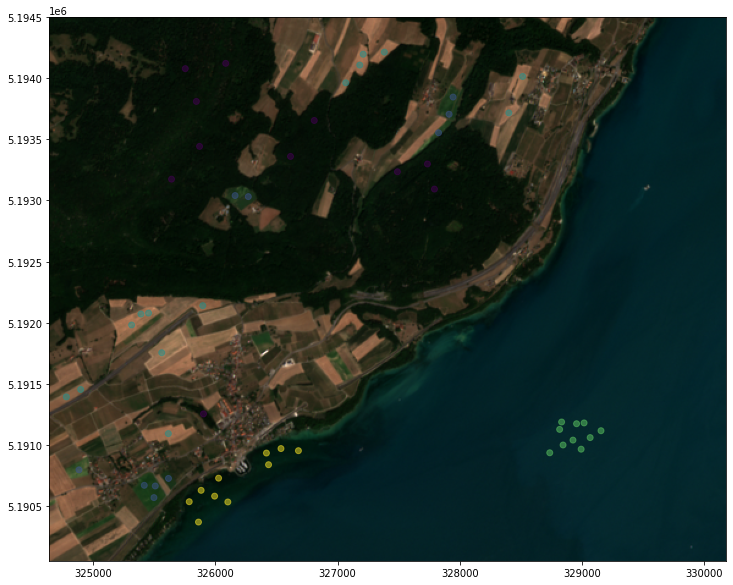

In [30]:
fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
ground_data.plot(column='land_cover_id', ax=ax, alpha=0.5)

#### Final Attributes

This is where we add the ground reference labels to the segments. A spatial join will add the attributes from the labeled points to the segment polygons. You can see in the few records printed below that all attributes, plus the land-cover class labels, are contained in the output table.

In [31]:
# Do geopandas spatial joins with the ground reference data
labeled = gpd.sjoin(vout, ground_data)
labeled.head()

,geometry,blue_mean,green_mean,red_mean,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn,index_right,land_cover_desc,land_cover_id
116,"POLYGON ((327180.000 5194270.000, 327210.000 5...",0.236790,0.283851,0.357277,0.457144,9100.0,520.0,0.882695,10.764051,16.382787,7.699017,0.246523,0.014692,0.012439,104,31,grassland-light,3
129,"POLYGON ((327400.000 5194310.000, 327440.000 5...",0.227513,0.273107,0.341411,0.464600,18400.0,840.0,0.941872,15.306080,27.136298,9.117012,-0.830723,0.021633,0.019252,74,30,grassland-light,3
153,"POLYGON ((327160.000 5194200.000, 327170.000 5...",0.230699,0.273954,0.342413,0.440230,13500.0,660.0,0.466506,13.110581,14.626315,12.937241,0.494906,0.016768,0.012536,127,32,grassland-light,3
187,"POLYGON ((325710.000 5194200.000, 325720.000 5...",0.125434,0.140760,0.126093,0.443133,65300.0,2080.0,0.862691,28.834449,42.896843,21.694314,1.514657,0.042070,0.025380,136,10,forest,1
206,"POLYGON ((326050.000 5194280.000, 326070.000 5...",0.126310,0.144178,0.127034,0.448572,48800.0,1660.0,0.799696,24.926711,34.401002,20.654534,0.236249,0.040239,0.022241,112,12,forest,1


<div class="alert alert-info" role="alert">

## <a id='classification'></a>4. Classification
[Back to top](#TOC_TOP)

</div>

## Classification algorithms
Your classification algorithm options are broad.

This tutorial selects RandomForests to classify the segments based on their attributes.

In [32]:
# Names of columns to be used in the classification
predictors = ["blue_mean", "green_mean", "red_mean", "nir_mean", "area", "perimeter", "major_axis_length", "edges_mean"]

# labeled is the Geopandas dataframe with attributes and labels. X is the selected columns of the data for training.
# y is the selected label column the corresponds to the data in X.
X = labeled[predictors]
y = labeled[["land_cover_id"]]

# This splits X and y into test and training sets. One-third of the training segments are randomly selected for the test set. 
# Two-thirds are randomly selected for the training set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

#### Supervised Learning
##### Training and Testing Sets

In [33]:
clf = rfc(max_depth=5, random_state=0)

clf.fit(X_train, np.ravel(y_train))

# Assess training accuracy
# ...of the training set
train_prediction = clf.predict(X_train)
print(f"Overall accuracy of the training set: {round(accuracy_score(y_train, train_prediction)*100, 2)}%")

# ...of the test set
test_prediction = clf.predict(X_test)
print(f"Overall accuracy of the test set: {round(accuracy_score(y_test, test_prediction)*100, 2)}%")

Overall accuracy of the training set: 100.0%
Overall accuracy of the test set: 89.47%


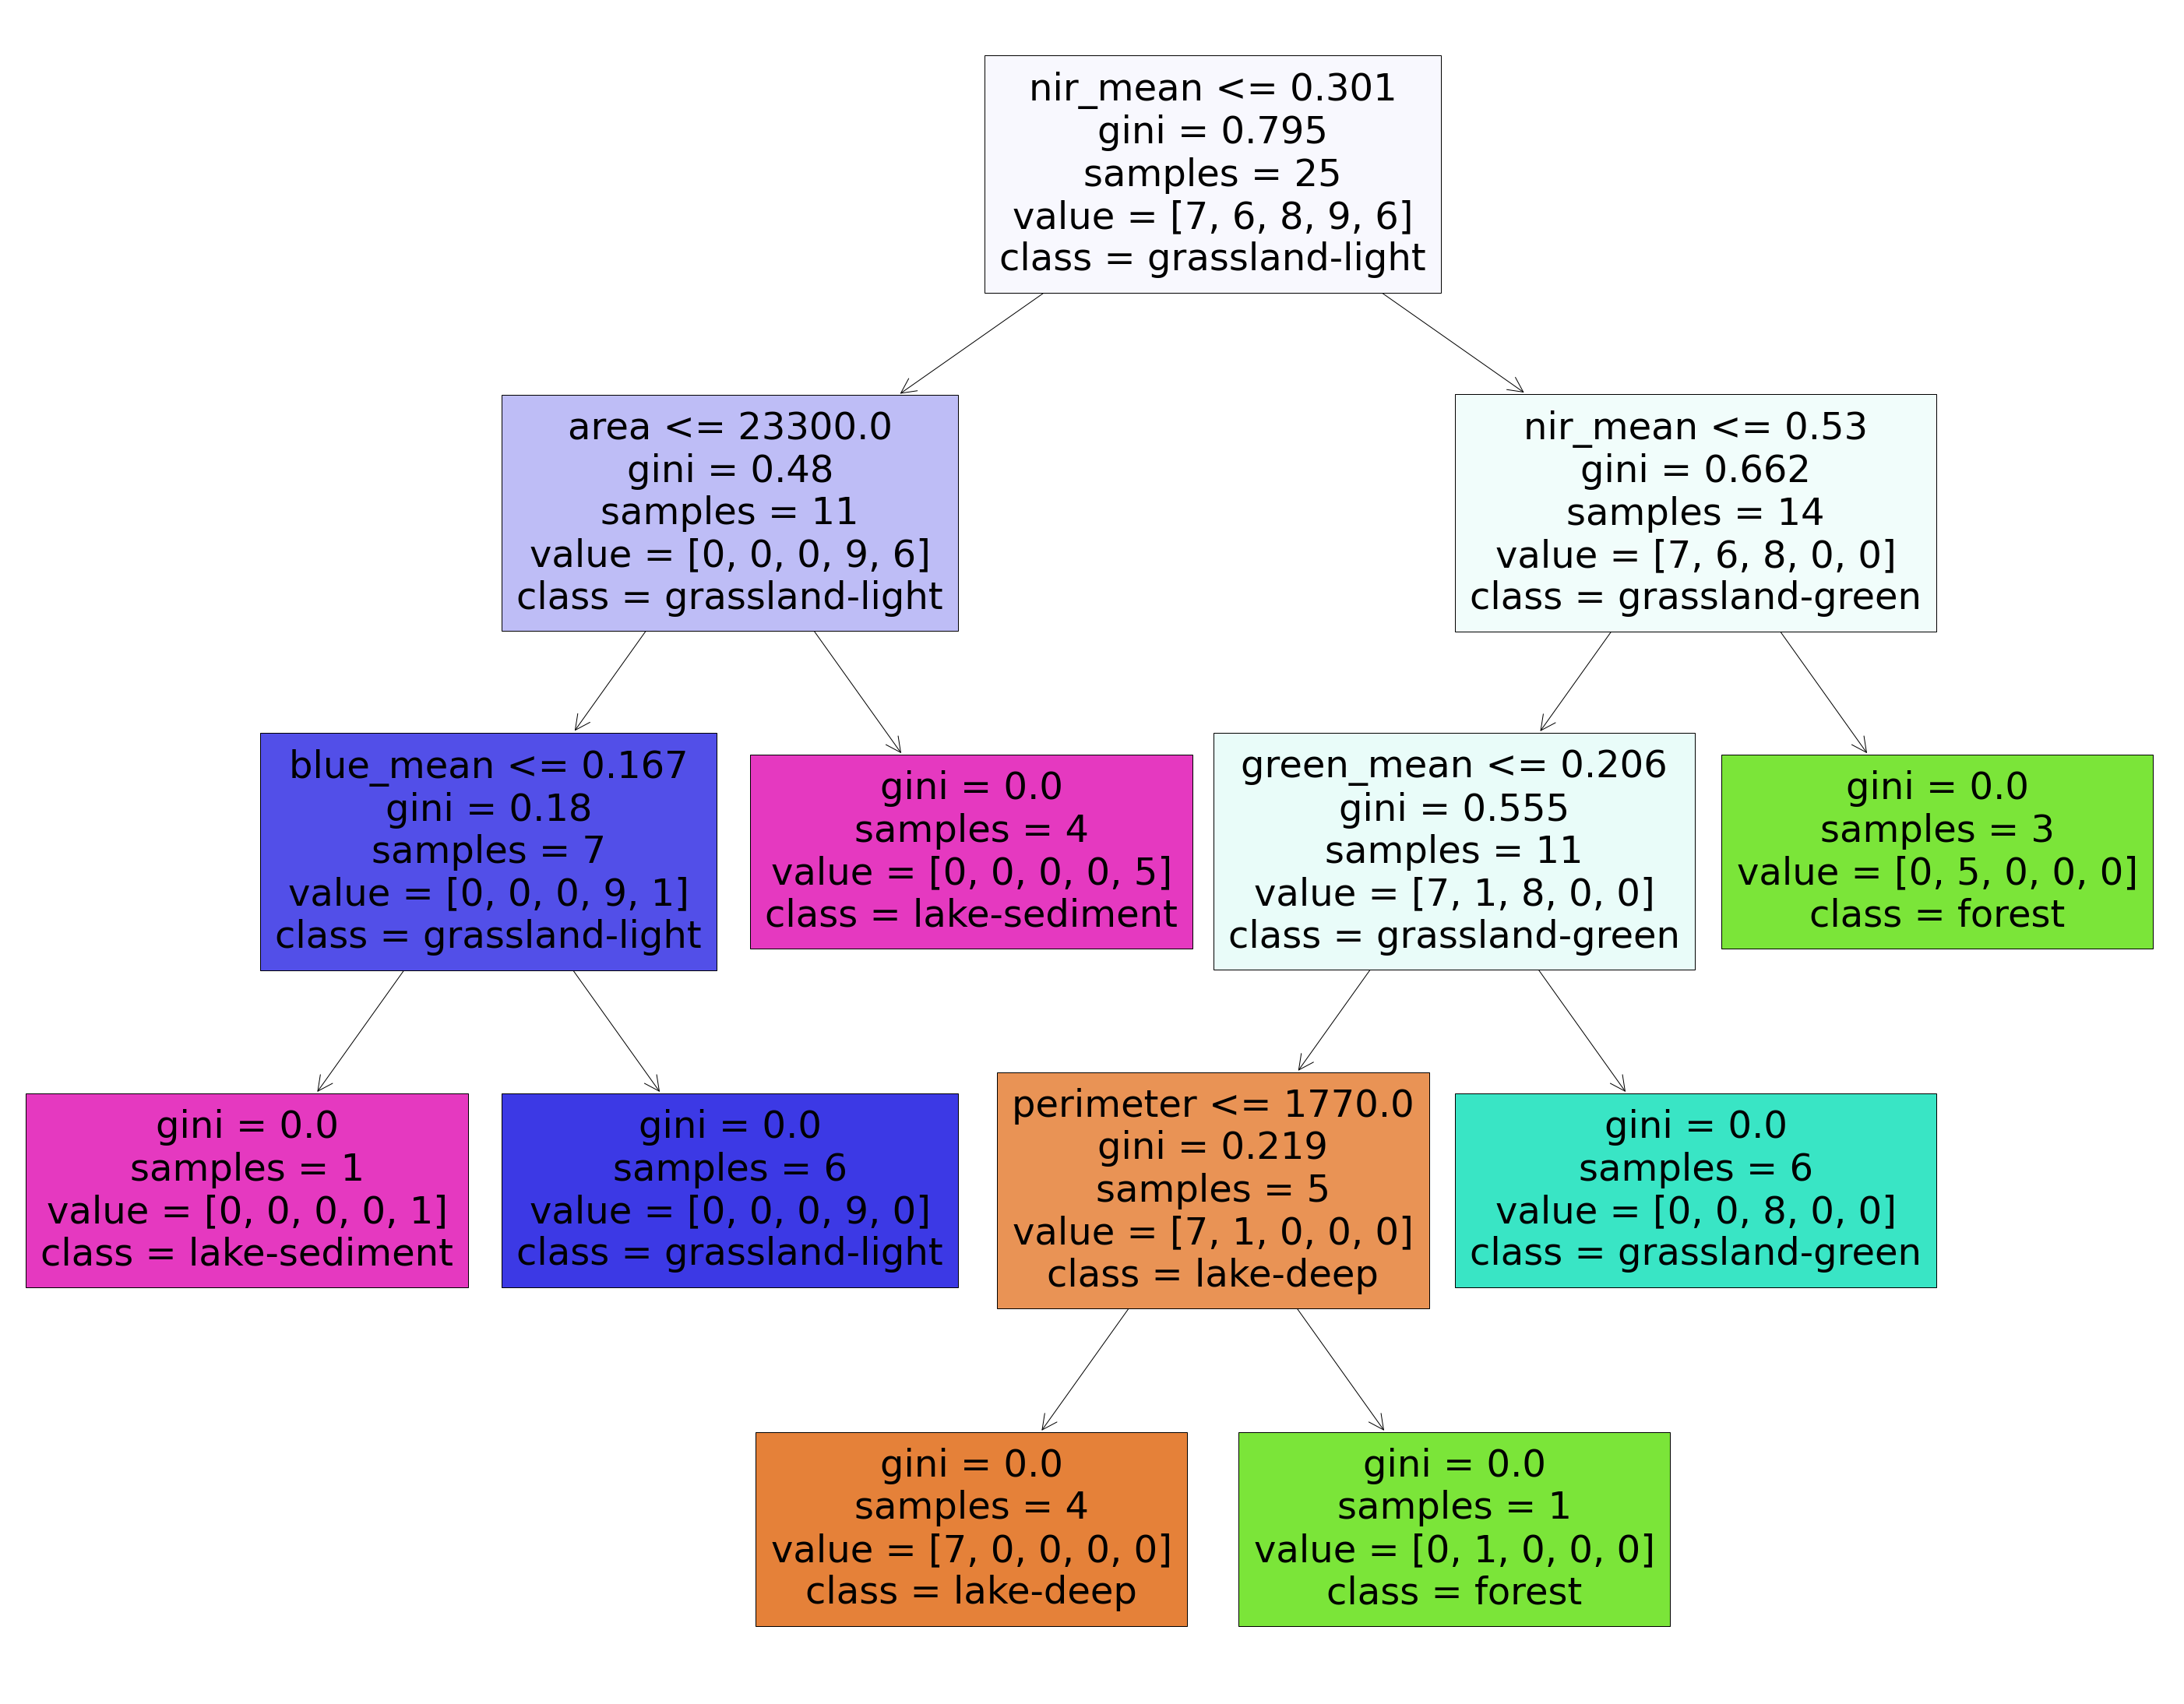

In [34]:
fig = plt.figure(figsize=(50,40))
annotations = tree.plot_tree(clf.estimators_[0], feature_names=predictors, class_names=lc_labels, filled=True)

#### Now let's prune the tree

In [35]:
pruned_clf = rfc(max_depth=5, min_samples_leaf=0.05, random_state=0)

pruned_clf.fit(X_train, np.ravel(y_train))

# Assess training accuracy
# ...of the training set
pruned_train_prediction = pruned_clf.predict(X_train)
print(f"Overall accuracy of the training set: {round(accuracy_score(y_train, pruned_train_prediction)*100, 2)}%")

# ...of the test set
pruned_test_prediction = pruned_clf.predict(X_test)
print(f"Overall accuracy of the test set: {round(accuracy_score(y_test, pruned_test_prediction)*100, 2)}%")

Overall accuracy of the training set: 97.22%
Overall accuracy of the test set: 89.47%


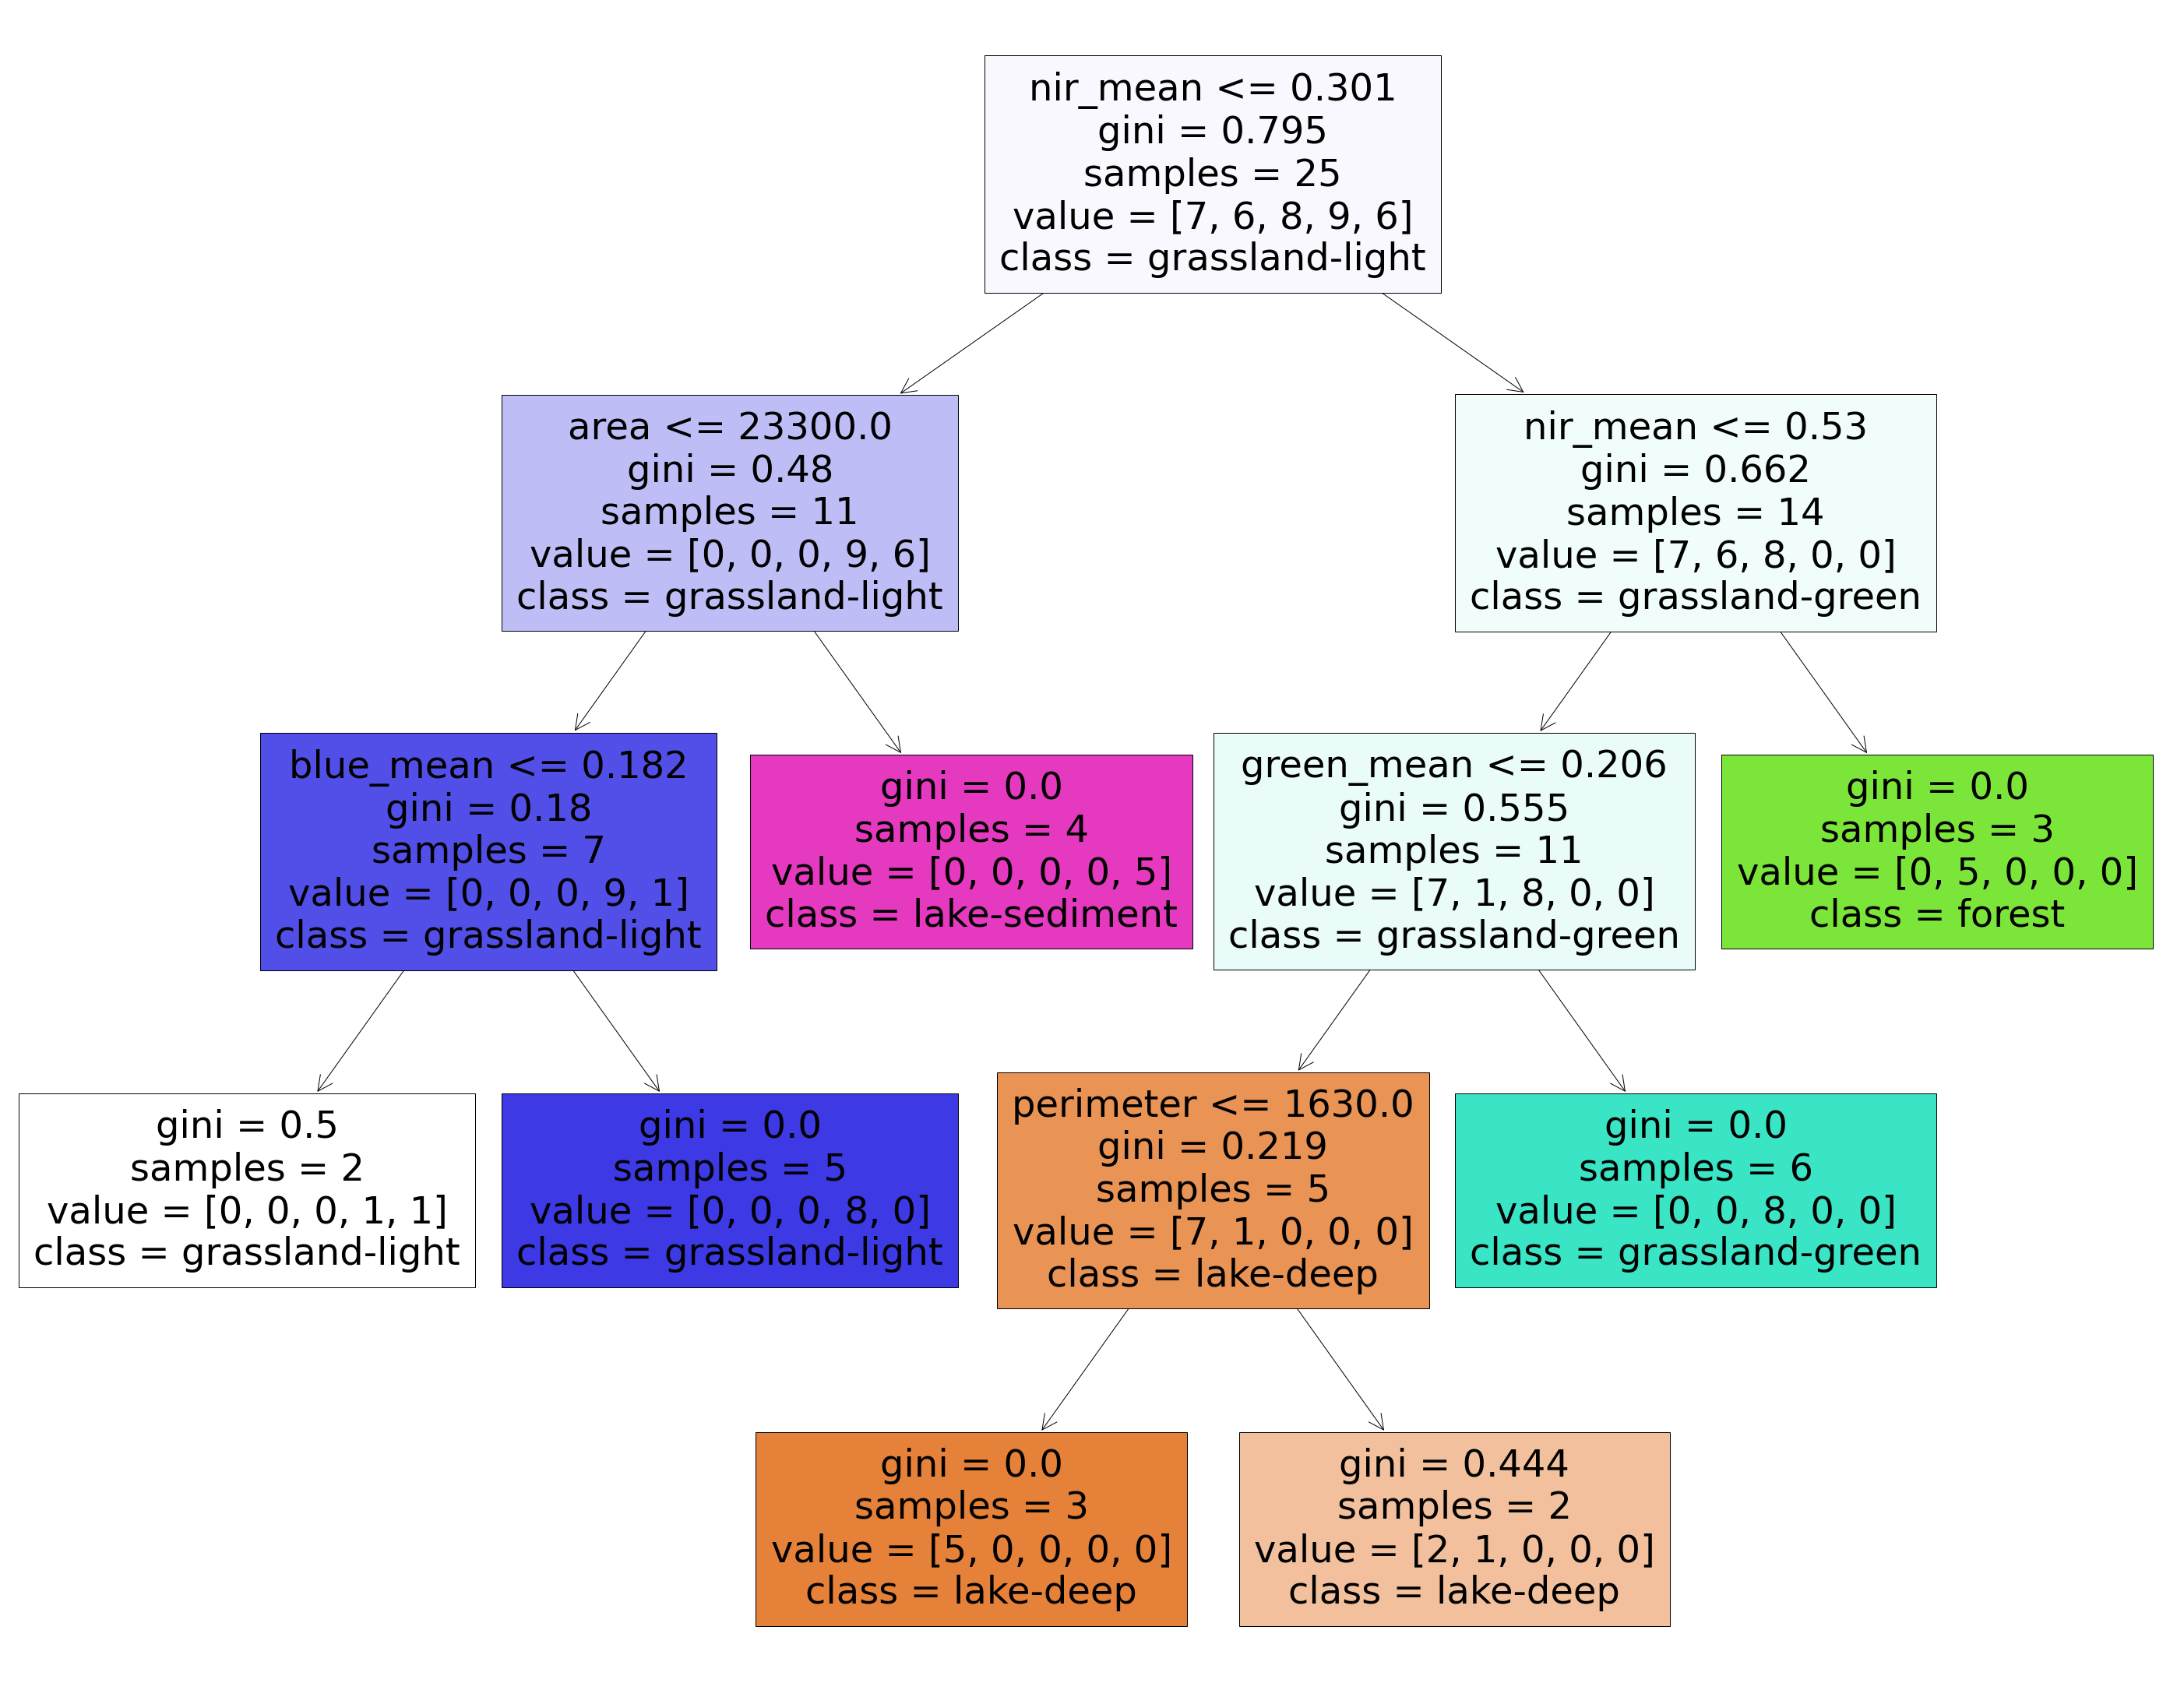

In [36]:
fig = plt.figure(figsize=(50,40))
annotations = tree.plot_tree(pruned_clf.estimators_[0], 
                             feature_names=predictors,
                             class_names=lc_labels,
                             filled=True)

In [37]:
full_prediction = pruned_clf.predict(vout[predictors])
output = vout
output['prediction'] = full_prediction
output.head()

,geometry,blue_mean,green_mean,red_mean,nir_mean,area,perimeter,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,orientation,edges_mean,edges_std,dn,prediction
0,"POLYGON ((327480.000 5194500.000, 327480.000 5...",0.127649,0.145959,0.134366,0.563924,4100.0,340.0,0.945644,7.225152,12.741393,4.143561,1.440833,0.034164,0.024765,1,1
1,"POLYGON ((325060.000 5194500.000, 325060.000 5...",0.126919,0.144490,0.124561,0.503557,7200.0,440.0,0.657429,9.574615,11.696544,8.813541,1.436558,0.046957,0.025664,6,1
2,"POLYGON ((326310.000 5194500.000, 326310.000 5...",0.141432,0.165116,0.153372,0.481581,11200.0,520.0,0.761851,11.941643,15.305014,9.913859,1.395996,0.045063,0.024198,7,2
3,"POLYGON ((328330.000 5194500.000, 328330.000 5...",0.156824,0.184952,0.192864,0.427598,11600.0,500.0,0.642805,12.153016,14.218704,10.891953,1.413716,0.024753,0.017278,3,2
4,"POLYGON ((328630.000 5194500.000, 328630.000 5...",0.174969,0.207304,0.228889,0.420451,10600.0,620.0,0.818265,11.726460,17.666837,10.155622,1.305706,0.023488,0.014566,4,2


<AxesSubplot:>

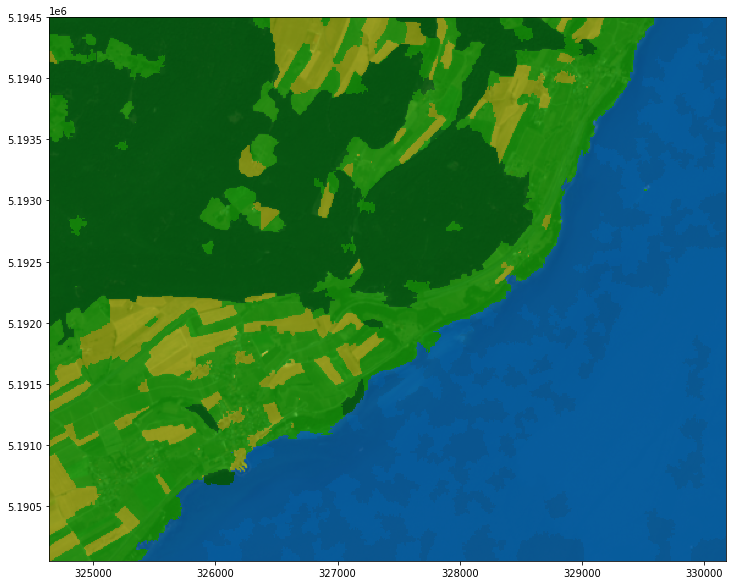

In [48]:
# This is used to apply a custom color scheme to the figure below
# Dark green = forest, Light green = grassland-green, Yellow = grassland-light, Light blue = lake-deep, Dark blue = lake-sediment
output['color'] = output['prediction'].apply(bin_mapping)

fig, ax = plt.subplots(figsize=(14,10))
img_extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax.use_sticky_edges = True
ax.imshow(bsq_to_bip(rgb_composite(rgb, 2, 1, 0)), extent=img_extent)
output.plot(column='prediction', cmap=lc_cmap, ax=ax, alpha=0.7)

<div class="alert alert-danger" role="alert">

## <a id='challenge'></a>Challenge.
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning">

### Challenge:

A final section of your notebook could invite the user to try and adapt your notebook for their own purposes. This is not necessary but can really help people to learn by applying their new knowled
 <div>

<div class="alert alert-danger" role="alert">

## <a id='challenge'></a>Challenge complete!
[Back to top](#TOC_TOP)

</div>

# A few straggling snippets

In [31]:
# slic_params = {
#     'n_segments': 3000,           # default = 100
#     'compactness': 2.5,       # default = 10.0 # 0.0001 or 0.00001 and zero=True
#     'max_num_iter': 20,           # default = 10
#     'sigma': 0,                   # default = 0
#     'convert2lab': True,          # default = None, but True is highly recommended for RGB images
#     'enforce_connectivity': True, # default = True
#     'min_size_factor': 0.5,       # default = 0.5
#     'max_size_factor': 3,         # default = 3
#     'slic_zero': True,            # default = False (if True, runs zero parameter version of SLIC)
#     'channel_axis': 2             # for our RGB image this should always be 2
# }

# felz_params = {
#     'scale': 2.7,      # default = 1
#     'sigma': 0.4,      # default = 0.8
#     'min_size': 22,    # default = 20
#     'channel_axis': 2  # for our RGB image this should always be 2
# }

# quickshift_params = {
#     'ratio': 0.5,           # default = 1
#     'kernel_size': 2,       # default = 5
#     'max_dist': 5,          # default = 10
#     'sigma': 0.2,           # default = 0
#     'convert2lab': True,    # default = True
#     'channel_axis': 2       # for our RGB image this should always be 2
# }

In [30]:
# SLIC
# rout = segmentation(model=slic, params=slic_params, image=image[:3])

# Felzenszwalb
# rout = segmentation(model=felzenszwalb, params=felz_params, image=image[:3], sieve_size=30)

# Quickshift
# rout = segmentation(model=quickshift, params=quickshift_params, image=image[:3], sieve_size=20)

In [29]:
# with rasterio.open("data/concise.tif") as src:
#     slic_params = {
#         'compactness': 0.00001,
#         'n_segments': 3000,
#         'slic_zero': True,
#         'convert2lab': True,
#         'enforce_connectivity': True
#     }

#     felz_params = {
#         'scale': 0.0001,
#         'sigma': 0.7,
#         'min_size': 10
#     }
    
#     # Works pretty good
#     quickshift_params = {
#         'channel_axis': 2,
#         'ratio': 0.009,
#         'sigma': 1.3,
#         'convert2lab': True
#     }

#     image = src.read()

#     print(f"Starting segmentation.", end="...")
    
#     # SLIC
#     # rout = segmentation(model=slic, params=slic_params, image=image[:3])
    
#     # Quickshift
#     rout = segmentation(model=quickshift, params=quickshift_params, image=image[:3], sieve_size=20)
    
#     # Felzenszwalb
#     # rout = segmentation(model=felzenszwalb, params=felz_params, image=image[:3], sieve_size=30)
    
#     print(f"done.")
    
#     print(f"Starting vectorization.", end="...")
#     vout = vectorize(image=rout, transform=src.transform,
#                     crs=src.crs.to_proj4())
#     print(f"done.")
    
#     print(f"Starting add zonal spectral properties.", end="...")
#     vout = add_zonal_properties(image=image, transform=src.transform, 
#                                 band_names=['blue', 'green', 'red', 'nir'],
#                                 gdf=vout)
#     print(f"done.")
    
#     print(f"Starting add shape properties.", end="...")
#     vout = add_shape_properties(rout, vout, ['area', 'perimeter',
#                                             'eccentricity', 
#                                             'equivalent_diameter',
#                                             'major_axis_length',
#                                             'minor_axis_length',
#                                             'orientation'])
#     print(f"done.")
    
#     print(f"Starting edge detection.", end="...")
#     edges = sobel_edge_detect(image[3])
#     print(f"done.")
    
#     print(f"Starting add zonal texture properties.", end="...")
#     vout = add_zonal_properties(image=edges, band_names=['edges'],
#                                 stats=['mean', 'std'],
#                                 transform=src.transform, gdf=vout)
#     print(f"done.")
    
#     vout.to_file("./segmentation.gpkg", layer="ss1000", driver="GPKG")
    
#     print("\nAll done!!")